# Goals

1. To be able to implement a simple end-to-end example of Paltas
2. To understand how each of the packages inter-communicate, and which packages need to be run (and when), to perform hierarchichal inference.

# Import Packages

In [1]:
paltas_directory = '/mnt/zfsusers/hollowayp/paltas/'
training_directory = '/mnt/extraspace/hollowayp/paltas_data/Example_F/'
import os
os.chdir(paltas_directory)
import paltas
from paltas.Analysis.AnalysisConfigs.train_config_examp import learning_params,batch_size,flip_pairs,\
                                                               n_epochs,random_seed,norm_images,\
                                                               loss_function,model_type,directory_to_save_model,\
                                                               npy_folders_train,img_size
from paltas.Analysis import hierarchical_inference,dataset_generation, loss_functions, conv_models
import matplotlib.pyplot as pl
from scipy.stats import norm
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np
import corner
import emcee
import numba
import h5py
import glob
np.random.seed(random_seed)
tf.random.set_seed(random_seed)


/mnt/zfsusers/hollowayp/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


# Generate Images

In [ ]:
folder = directory_to_save
!python3 ./paltas/generate.py ./paltas/Configs/Examples/config_simple.py ./$directory_to_save/training --n 2 --tf_record --h5
!python3 ./paltas/generate.py ./paltas/Configs/Examples/config_simple.py ./$directory_to_save/validation --n 2 --tf_record --h5


# Train Model

In [ ]:
!python3 ./paltas/Analysis/train_model.py ./paltas/Analysis/AnalysisConfigs/train_config_examp.py --h5

# Generate and Save Model Predictions

FINAL EPOCH 200--6.28.h5


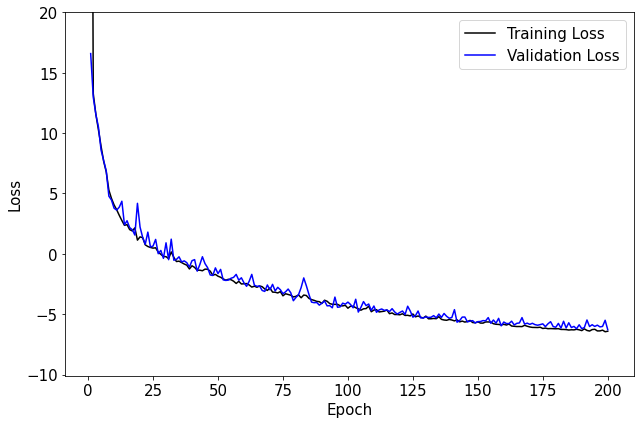

In [60]:
def load_model_weights_list(directory):
    """ Function to return a list of weights filenames from the network
    args: Directory containing the training, validation and weights files """
    weights_list = glob.glob(directory+'./model_weights/*')
    weights_list = [elem.split('model_weights/')[1] for elem in weights_list]
    return weights_list

def return_final_epoch_weights(directory):
    """ File to return the weight filename of the final trained epoch
    args: Directory containing the training, validation and weights files """
    weights_list = load_model_weights_list(directory)
    final_epoch =  np.max([int(elem.split('-')[0]) for elem in a])
    w_filename = [x for x in weights_list if x.startswith("{:02d}".format(final_epoch)+'-')][0]
    print('FINAL EPOCH',w_filename)
    return directory+'/model_weights/'+w_filename

def plot_loss_curves(directory,ymax=None):
    db_loss = pd.read_csv(directory)
    fig,ax = pl.subplots(1,figsize=(9,6))
    ax.plot(db_loss['epoch'],(db_loss['loss']),c='k')
    ax.plot(db_loss['epoch'],(db_loss['val_loss']),c='blue')
    ax.set_xlabel('Epoch',fontsize=15)
    ax.set_ylabel('Loss',fontsize=15)
    if ymax is not None: ax.set_ylim(top=ymax)
    ax.tick_params(labelsize=15)
    pl.legend(['Training Loss','Validation Loss'],fontsize=15)
    pl.tight_layout()
    pl.show()

a = load_model_weights_list(training_directory)
d = return_final_epoch_weights(training_directory)
plot_loss_curves(training_directory+'/loss_function_db.csv',ymax=20)

## Configuration

In [61]:
def load_model(model_weights_filename,loss_type,model_type,learning_params,log_learning_params,img_size):
    """ Loads the trained model
    args: 
    model_weights_filename (str): .h5 file containing the weights of the trained model.
    loss_type (str): 'full' or 'diag', depending on the type of covariance matrix chosen
    model type (str): 'xresnet34' or 'xresnet101', according to the choice of network
    learning_params (list of str): Parameters learnt by the network
    log_learning_params (list of str): XXXXXX
    img_size (int): Dimensions of the input images"""
    num_params = len(learning_params+log_learning_params)
    if loss_type == 'full':
        num_outputs = num_params + int(num_params*(num_params+1)/2)
        loss_func = loss_functions.FullCovarianceLoss(num_params)
    elif loss_type == 'diag':
        num_outputs = 2*num_params
        loss_func = loss_functions.DiagonalCovarianceLoss(num_params)
    if model_type == 'xresnet101':
        model = conv_models.build_xresnet101(img_size,num_outputs)
    if model_type == 'xresnet34':
        model = conv_models.build_xresnet34(img_size,num_outputs)
#SKIPPING MISSMATCH WHEN LOADING WEIGHTS - IS THIS BAD????? NEED TO CHECK IF IT STILL BREAKS IF DON'T HAVE THIS
    model.load_weights(model_weights_filename,by_name=True,skip_mismatch=True)
    return model

model = load_model(training_directory,loss_type,learning_params,log_learning_params,model_type)
learning_params_print = learning_params


FINAL EPOCH 200--6.28.h5


100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


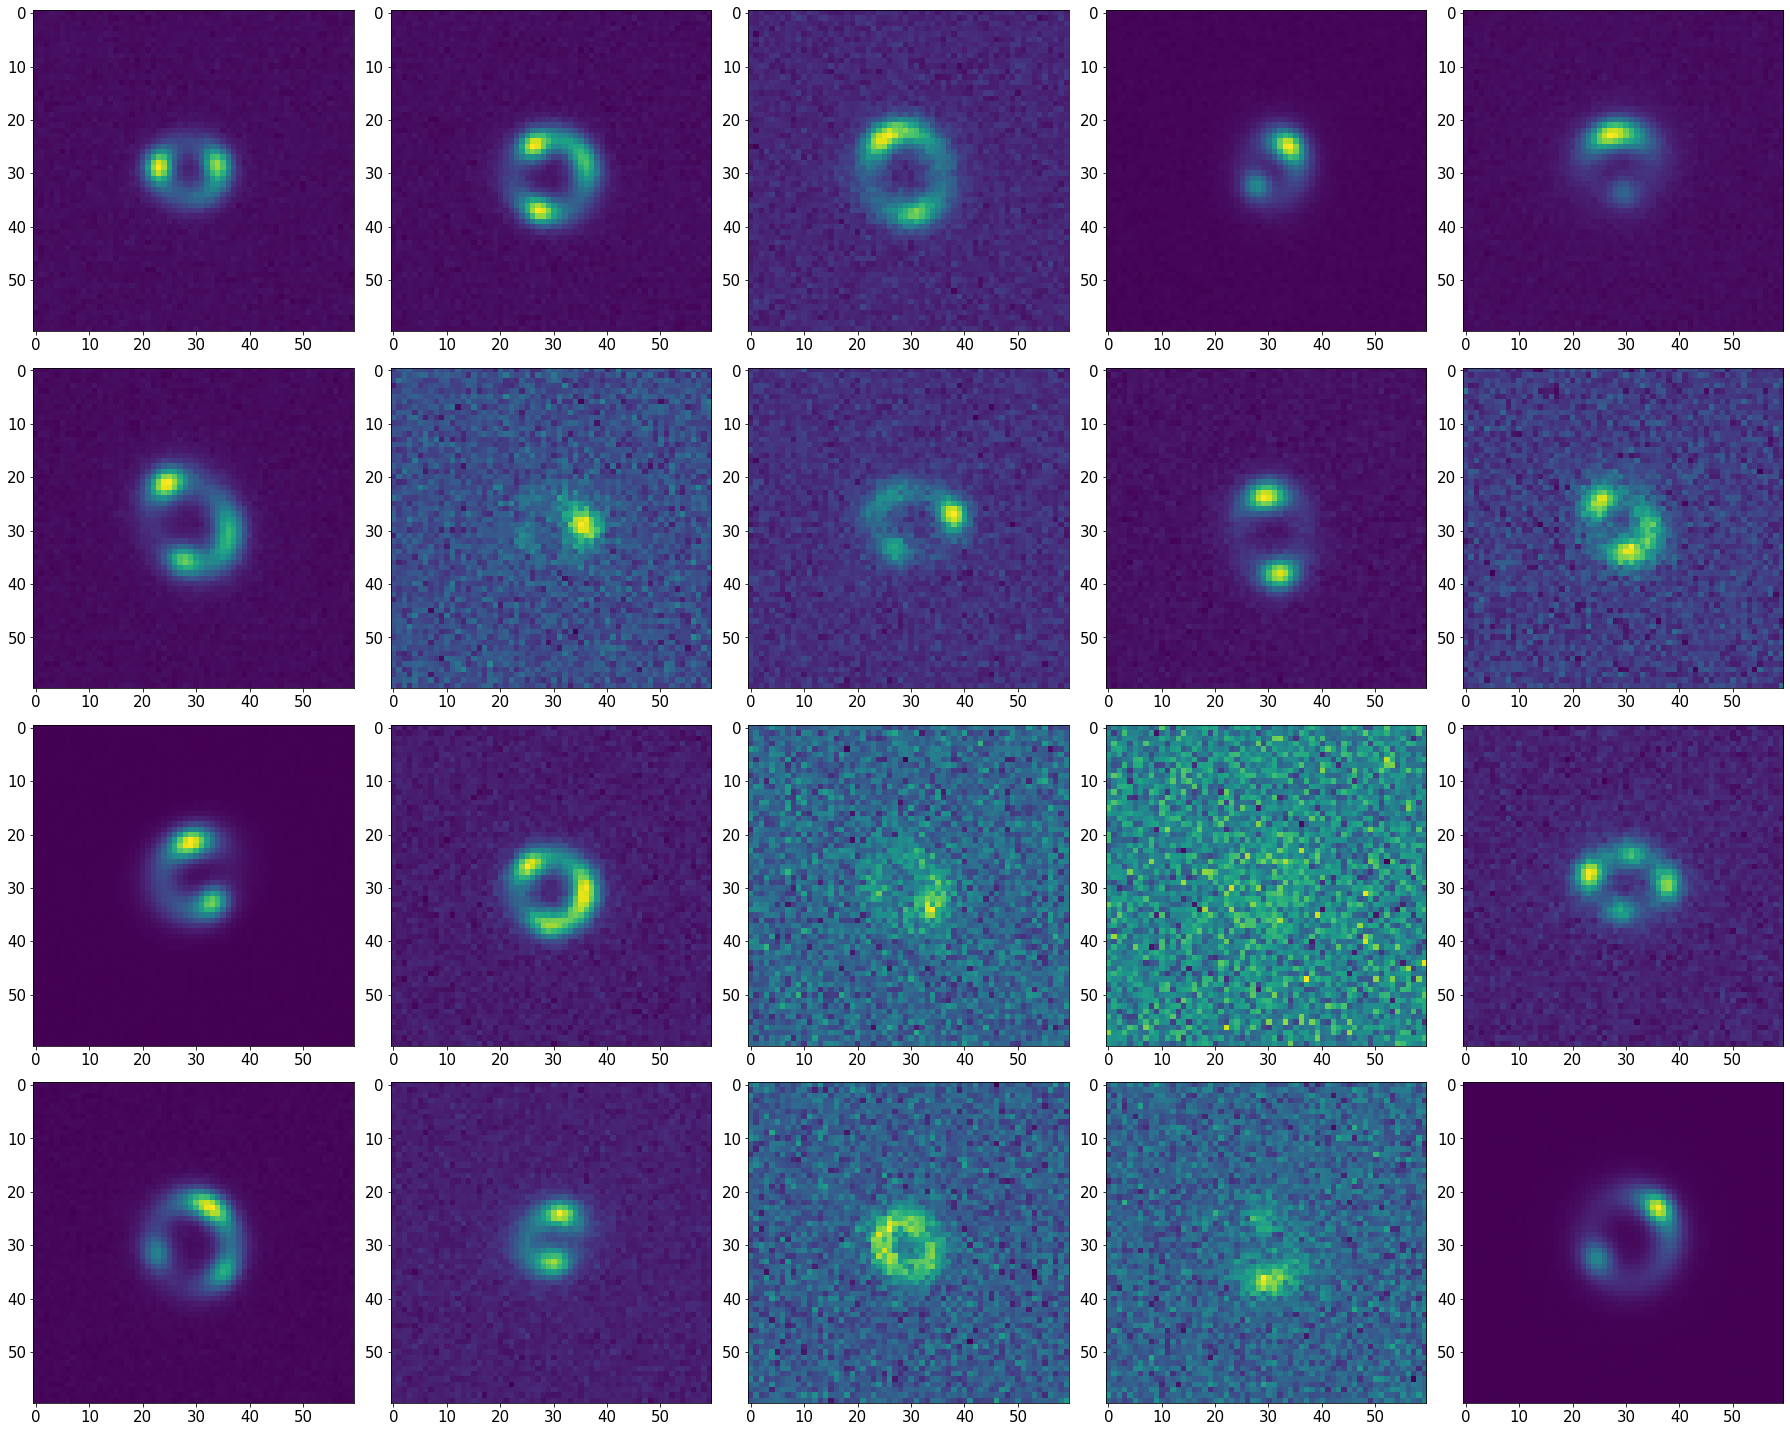

In [81]:
training_set = load_training_images(training_directory+'/training/' ,1,1)



In [ ]:
#training_set = load_training_images(f_train,1,100)
def plot_image_collage(image_data,N_images,random_sample=True,N_columns=5,logscale=False):
    N_rows = np.ceil(N_images/N_columns).astype('int')
    if random_sample: image_sample = image_data[np.random.choice(np.arange(len(image_data)),size=N_images,replace=False)]
    else: image_sample = image_data[0:N_images]
    fig,ax = pl.subplots(N_rows,N_columns,figsize=(5*N_columns,5*N_rows))
    for i in range(N_images):
        if logscale: image_sample[i]=np.log10(image_sample[i])
        ax[int(i/N_columns),i%N_columns].imshow(image_sample[i])
        ax[int(i/N_columns),i%N_columns].tick_params(labelsize=15)
    for j in range(i+1,N_rows*N_columns):
        ax[int(j/N_columns),j%N_columns].remove()
    pl.tight_layout()
    pl.show()

#plot_image_collage(image_data=training_set,N_images=11,logscale=False)
plot_image_collage(image_data=training_set,N_images=20,N_columns=5,logscale=False)



In [4]:
def load_training_images(f_train,f_min,f_max):
    image_dict = {}
    for file_n in tqdm(np.arange(f_min,f_max+1,1).astype('str')):
        with h5py.File(f_train+file_n+'/image_data.h5', "r") as f:
            image_dict[file_n] = f['data'][()]
    return np.concatenate([image_dict[elem] for elem in image_dict.keys()])

def load_validation_images(f_val):
    with h5py.File(f_train+'/1/'+'/image_data.h5', "r") as f:
        val_set = f['data'][()]
    return val_set

f_train =training_directory+'/training/'
f_val = training_directory + '/validation/'
#training_set = load_training_images(f_train,1,100)
#validation_set = load_validation_images(f_val)

In [146]:
from paltas.Analysis.train_model import *

def load_tf_dataset():
    #Loads batch of training and validation data
    tf_params=main(args = {'h5':True,'tensorboard_dir':None,\
             'training_config':'./paltas/Analysis/AnalysisConfigs/train_config_examp.py'},\
         return_data_args=True)
    #Does NOT perform rotation of images, even if the images are rotated in the training:
    tf_params['all_epochs']=1
    tf_params['batch_size']=1000
    print('NORM',tf_params['norm_images'],tf_params['input_norm_path'])
    tf_dataset_t = dataset_generation.generate_tf_dataset(tf_params['tfr_train_paths'],
        tf_params['all_params'],\
        tf_params['batch_size'],\
        tf_params['all_epochs'],\
        norm_images = tf_params['norm_images'],\
        input_norm_path=tf_params['input_norm_path'],\
        kwargs_detector=tf_params['kwargs_detector'],\
        log_learning_params=tf_params['log_learning_params'])
    tf_dataset_v = dataset_generation.generate_tf_dataset(tf_params['tfr_val_path'],\
    tf_params['all_params'],tf_params['number_mix'],1,\
    norm_images=tf_params['norm_images'],input_norm_path=tf_params['input_norm_path'],\
    kwargs_detector=None,log_learning_params=tf_params['log_learning_params'])
#NB: This seems to not be defined anywhere so is just an empty list?
    if tf_params['params_as_inputs']:
        tf_dataset_t = dataset_generation.generate_params_as_input_dataset(
            tf_dataset_t,params_as_inputs,all_params+log_learning_params)
        tf_dataset_v = dataset_generation.generate_params_as_input_dataset(
            tf_dataset_v,params_as_inputs,all_params+log_learning_params)
    data_dict = {}
    print(tf_dataset_v)
    for batch in tf_dataset_t:
        data_dict['train_images'] = batch[0].numpy()
        data_dict['train_labels'] = batch[1].numpy()
        break
    for batch in tf_dataset_v:
        data_dict['val_images'] = batch[0].numpy()
        data_dict['val_labels'] = batch[1].numpy()
        break
    return data_dict

data_dict=load_tf_dataset()

<paltas.Analysis.train_model.parse_input_args.<locals>.args_class object at 0x7f63581868d0> True None ./paltas/Analysis/AnalysisConfigs/train_config_examp.py
N_VAL_NPY 1000
Checking for training data.
TFRecord found at /mnt/extraspace/hollowayp/paltas_data/Example_F//training/61/data.tfrecord
TFRecord found at /mnt/extraspace/hollowayp/paltas_data/Example_F//training/17/data.tfrecord
TFRecord found at /mnt/extraspace/hollowayp/paltas_data/Example_F//training/74/data.tfrecord
TFRecord found at /mnt/extraspace/hollowayp/paltas_data/Example_F//training/12/data.tfrecord
TFRecord found at /mnt/extraspace/hollowayp/paltas_data/Example_F//training/54/data.tfrecord
TFRecord found at /mnt/extraspace/hollowayp/paltas_data/Example_F//training/23/data.tfrecord
TFRecord found at /mnt/extraspace/hollowayp/paltas_data/Example_F//training/77/data.tfrecord
TFRecord found at /mnt/extraspace/hollowayp/paltas_data/Example_F//training/1/data.tfrecord
TFRecord found at /mnt/extraspace/hollowayp/paltas_data/

val path /mnt/extraspace/hollowayp/paltas_data/Example_F/validation/1/data.tfrecord 256
NORM True /mnt/extraspace/hollowayp/paltas_data/Example_F//training/61/norms.csv
<PrefetchDataset shapes: ((None, None, None, 1), (None, 8)), types: (tf.float32, tf.float32)>


DataLossError: truncated record at 13876503' failed with Read less bytes than requested [Op:IteratorGetNext]

In [114]:
def plot_loss_function_manually():
    w_min = 197
    w_max = 200
    weights_list = load_model_weights_list(training_directory)
    t_loss_list = []
    v_loss_list = []
    for w_number in tqdm(np.arange(w_min,w_max+1,1)):
        w_filename = [x for x in weights_list if x.startswith("{:02d}".format(w_number)+'-')][0]
        model = load_model(training_directory+'model_weights/'+\
                           w_filename,loss_type,model_type,learning_params,[],img_size)
        output_train = model.predict(data_dict['train_images'])
        output_val = model.predict(data_dict['val_images'])
        t_loss_list.append(np.mean(loss_func.loss(data_dict['train_labels'],output_train).numpy()))
        v_loss_list.append(np.mean(loss_func.loss(data_dict['val_labels'],output_val).numpy()))
    pl.plot(np.arange(w_min,w_max+1,1),t_loss_list)
    pl.plot(np.arange(w_min,w_max+1,1),v_loss_list)
    pl.legend(['t_loss','v_loss'])
    pl.yscale('log')
    pl.show()


## def gen_network_predictions

In [5]:
##############################
# generate network predictions
##############################
def gen_network_predictions(test_folder,norm_path,learning_params,loss_type,
                            loss_func,model,samples=False,shuffle=True,
                            norm_images=True,log_norm_images=False):
    """
    Generate neural network predictions given a paltas generated folder of images

    Args:
        test_folder (string): Path to folder of paltas generated images, 
            containig a data.tfrecord file
        norm_path (string): Path to .csv containing normalization of parameters
            applied during training of network
        learning_params (list(string)): Names of parameters learned
        loss_type (string): 'full' or 'diag' currently supported
        loss_func (paltas.Analysis.loss_function): Loss function object, (needs
            draw_samples() and convert_output() functionality)
        model (paltas.Analysis.conv_models): Trained neural network with weights
            loaded
        samples (bool, default=False): If True, samples from the NPE are returned
        shuffle (bool, default=True): If True, the order of the test set is shuffled
            when generating predictions
        norm_images (bool, default=True): If True, normalize test set images
        log_norm_images (bool, default=False): If True, test set imags are
            log-normalized and rescaled to range (0,1)

    Returns:
        If samples=True:
            y_test, y_pred, std_pred, prec_pred, predict_samps
        Else:
            y_test, y_pred, std_pred, prec_pred
    """

    npy_folder_test = test_folder
    tfr_test_path = os.path.join(npy_folder_test,'data.tfrecord')
    input_norm_path = norm_path
    log_learning_params = []

    if loss_type not in {'full','diag'}:
        raise ValueError('loss_type not supported')

    tf_dataset_test = dataset_generation.generate_tf_dataset(tfr_test_path,learning_params,
        3,1,norm_images=norm_images,
        kwargs_detector=None,input_norm_path=input_norm_path,
        log_learning_params=log_learning_params,shuffle=shuffle)

    n_rotations = int(2)

    y_test_list = []
    y_pred_list = []
    std_pred_list = []
    cov_pred_list = []
    predict_samps_list = []

    for batch in tf_dataset_test:
        images = batch[0].numpy()
        y_test = batch[1].numpy()

        y_pred_rot_list = []
        for rot_angle in (np.random.uniform(size=n_rotations)*2*np.pi):
            image_rot = dataset_generation.rotate_image_batch(images,[],None,rot_angle)
            output = model.predict(image_rot)
            if loss_type == 'full':
                y_pred_rot,_,_ = loss_func.convert_output(output=output)
            else:
                y_pred_rot,_ = loss_func.convert_output(output)

            y_pred_rot = y_pred_rot.numpy()
            y_pred_rot_list.append(y_pred_rot)

        y_pred = np.mean(y_pred_rot_list,axis=0)
        
        # use unrotated output for covariance matrix
        output = model.predict(images)

        if loss_type == 'full':
            y_pred_no_rot, precision_matrix, _ = loss_func.convert_output(output)
        else:
            y_pred_no_rot, log_var_pred = loss_func.convert_output(output)
        
        # x & y need to be from the un-rotated predictions
        y_pred[:,6:8] = y_pred_no_rot[:,6:8]
        # TODO: fix this
        y_pred = y_pred_no_rot

        # compute std. dev.
        if loss_type == 'full':
            cov_mat = np.linalg.inv(precision_matrix.numpy())
            std_pred = np.zeros((cov_mat.shape[0],cov_mat.shape[1]))
            for i in range(len(std_pred)):
                std_pred[i] = np.sqrt(np.diag(cov_mat[i]))
            
        else:
            std_pred = np.exp(log_var_pred/2)
            cov_mat = np.empty((len(std_pred),len(std_pred[0]),len(std_pred[0])))
            for i in range(len(std_pred)):
                cov_mat[i] = np.diag(std_pred[i]**2)

        y_test_list.append(y_test)
        y_pred_list.append(y_pred)
        std_pred_list.append(std_pred)
        cov_pred_list.append(cov_mat)
        if samples:
            un_samples = loss_func.draw_samples(output,n_samps=10000)
            # trying to unnormalize samples correctly 
            # unnormalize_outputs() expects shape (batchsize,num_params)
            for j in range(0,un_samples.shape[1]):
                dataset_generation.unnormalize_outputs(input_norm_path,
                    learning_params+log_learning_params,
                    un_samples[:,j,:])
            predict_samps_list.append(un_samples)

    y_test = np.concatenate(y_test_list)
    y_pred = np.concatenate(y_pred_list)
    std_pred = np.concatenate(std_pred_list)
    cov_pred = np.concatenate(cov_pred_list)
    if samples:
        predict_samps = np.concatenate(predict_samps_list,axis=1)

    if input_norm_path is not None:
        print('UNNORMALISING OUTPUTS')
        print(np.mean(y_pred),np.mean(std_pred),np.mean(cov_pred))                            
        dataset_generation.unnormalize_outputs(input_norm_path,learning_params+log_learning_params,
                                        y_pred,standard_dev=std_pred,cov_mat=cov_pred)
        dataset_generation.unnormalize_outputs(input_norm_path,learning_params+log_learning_params,
                                        y_test)
        print(np.mean(y_pred),np.mean(std_pred),np.mean(cov_pred))                            
    prec_pred = np.linalg.inv(cov_pred)

    if samples:
        return y_test, y_pred, std_pred, prec_pred, predict_samps
    
    return y_test, y_pred, std_pred, prec_pred


## Save Network Predictions

In [147]:
#y_test, y_pred, std_pred, prec_pred

network_predictions = gen_network_predictions(\
                        test_folder=training_directory+'/validation/1',\
                        norm_path=training_directory+'/training/1/norms.csv',\
                        learning_params=learning_params,\
                        loss_type=loss_function,
                        loss_func=loss_func,\
                        model=model,samples=False,shuffle=True,
                        norm_images=norm_images,log_norm_images=False)

def save_network_predictions(network_predictions,filename):
    np.save(filename+'_test',network_predictions[0])
    np.save(filename+'_pred',network_predictions[1])
    np.save(filename+'_std_pred',network_predictions[2])
    np.save(filename+'_prec_pred',network_predictions[3])

save_network_predictions(network_predictions,\
                         training_directory+'/validation/1/predictions')


UNNORMALISING OUTPUTS
0.0060945856 0.4501396083324216 0.047618333
0.3875542 0.04333017495578814 0.00041281653


In [7]:
print('Test',np.mean(network_predictions[0],axis=0))
print('Pred',np.mean(network_predictions[1],axis=0))
print('Test',np.std(network_predictions[0],axis=0))
print('Pred',np.std(network_predictions[1],axis=0))

Test [ 1.0976278e+00 -2.7158060e-03  5.8022561e-04  2.0002635e+00
  4.9002850e-03  1.3971300e-04 -2.0933908e-03  2.7192608e-03]
Pred [ 1.1018867e+00 -1.7706836e-03  1.0584350e-03  2.0051374e+00
  1.7283091e-03  8.7707369e-03  1.0019548e-04  4.1512828e-03]
Test [0.14603598 0.04891665 0.04933416 0.10144079 0.09970479 0.10154891
 0.15459344 0.15290698]
Pred [0.14183196 0.03762982 0.04010309 0.04575222 0.06477756 0.06211203
 0.121655   0.12461254]


In [41]:
for p in [y_pred]:
    print('y_pred',np.std(p,axis=0))

for q in [train_mean,train_scatter]:#,network_prec]:
    print(q)

y_pred [0.14183196 0.03762982 0.04010311 0.04575223 0.06477758 0.06211204
 0.12165497 0.12461252]
[ 1.10314974e+00 -3.82165708e-03  2.86620934e-03  1.99706667e+00
  4.59652383e-03 -1.71987510e-04 -8.73461689e-03 -2.75836533e-03]
[0.15307457 0.04967475 0.04897056 0.09895394 0.1022993  0.10092042
 0.16100556 0.15559664]


-0.028172354978094078 1.0405703861599314


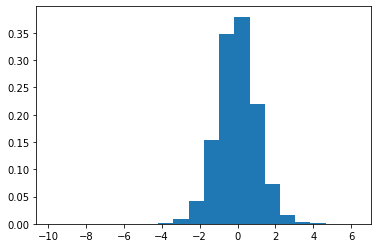

In [156]:
#y_test, y_pred, std_pred, prec_pred
sig_away = ((network_predictions[0]-network_predictions[1])/network_predictions[2]).flatten()
pl.hist(sig_away,bins=20,density=True)
print(np.mean(sig_away),np.std(sig_away))

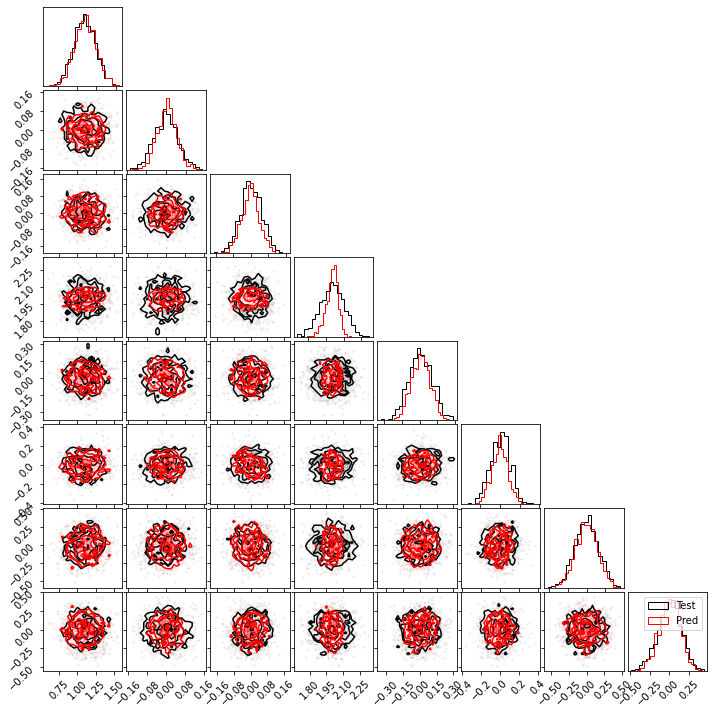

In [157]:
import corner
import matplotlib.pyplot as pl
fig = pl.figure(figsize=(10,10))
corner.corner(network_predictions[0],fig=fig,color='k')
corner.corner(network_predictions[1],fig=fig,color='red')
pl.legend(['Test','Pred'])
pl.show()


# Load Model Outputs

In [97]:
# Define the true population mean and its scatter
#SHOULD TAKE THESE FROM CONFIG FILE I THINK, NOT THE TRAINING DATA
#true_mean = np.array(pd.read_csv('/mnt/extraspace/hollowayp/paltas_data/Example_C/training/1/norms.csv')['mean']) #NB: In practice, this should be the true population mean not the 
#training mean - these may differ if the training is not a representative population (e.g. chosen to be gaussian).
#true_scatter = np.array(pd.read_csv('/mnt/extraspace/hollowayp/paltas_data/Example_C/training/1/norms.csv')['std']) #NB: ^^ Ditto

# Assume some consistent, large noise for all of our lens images
#image_information_scatter = np.random.uniform(low=4e-3,high=6e-3,size=100)
#image_mean = true_mean + np.random.normal(size=100)*image_information_scatter + np.random.normal(size=100)*true_scatter

# This in the mean and scatter of the information in each image, but remember our network predicts a posterior which means we need to multiply our likelihood
# by the training prior
train_mean = np.array(pd.read_csv(training_directory+'/training/1/norms.csv')['mean']) 
train_scatter = np.array(pd.read_csv(training_directory+'/training/1/norms.csv')['std']) 
#network_means = (image_mean * train_scatter**2 + train_mean*image_information_scatter**2)/(train_scatter**2 + image_information_scatter**2)
#network_scatter = np.sqrt((train_scatter**2 * image_information_scatter**2)/(train_scatter**2 + image_information_scatter**2))
network_means = np.load(training_directory+'/validation/1/predictions_pred.npy').astype('float64')
network_scatter = np.load(training_directory+'/validation/1/predictions_std_pred.npy').astype('float64')
network_prec = np.load(training_directory+'/validation/1/predictions_prec_pred.npy').astype('float64')
print(np.shape(network_scatter))
# Let's define a few of the parameters for our inference
n_lenses = 1000
n_emcee_samps = int(1e3)
burnin = int(1e2)

# Load the predictions for the mean and covariance for our model. We'll have to do a little reshaping here since the code
# expect an array of mean values and a precision matrix.
y_pred = network_means[:n_lenses].reshape((n_lenses,num_params))
#HAVE EDITED THE LINE BELOW - NOT SURE IF ITS RIGHT??
prec_pred = network_prec#/np.square(network_scatter[:n_lenses].reshape((n_lenses,num_params,num_params)))


(1000, 8)


In [94]:
np.shape(prec_pred)

(1000, 8, 8)

# Hierarchical Inference

In [241]:
def original_HI(n_lenses,y_pred,prec_pred,train_mean,train_scatter,n_param=None):
    print('SHAPES',[np.shape(elem) for elem in [y_pred,prec_pred,train_mean,train_scatter]])
    """
    Returns:
        sampler object
    """
    # Let's define a few of the parameters for our inference
    n_emcee_samps = int(1e4)

    # Load the predictions for the mean and covariance for our model. We'll have to do a little reshaping here since the code
    # expect an array of mean values and a precision matrix.
    y_pred_hi = y_pred#np.ascontiguousarray(y_pred[:n_lenses,:num_params]).reshape((n_lenses,num_params)).astype(np.float64)
    prec_pred_hi = prec_pred# np.ascontiguousarray(prec_pred[:n_lenses,:num_params,:num_params]).reshape((n_lenses,num_params,num_params)).astype(np.float64)
    # The interim training distribution.
    mu_omega_i = np.array(train_mean)
    cov_omega_i = np.diag(np.array(train_scatter)**2)
    if n_param is None: ndim =2*num_params
    else: ndim = 2*n_param
    # uniform prior with bounds
    @numba.njit()
    def eval_func_omega(hyperparameters):
        for i in range(ndim):
            if (np.abs(hyperparameters[i])>5):
                return -np.inf
        '''
        # theta_E
        if np.abs(1-hyperparameters[0]) > 0.4998:
            return -np.inf
        # gamma1/gamma2
        if np.abs(hyperparameters[1]) > 0.4 or np.abs(hyperparameters[2]) > 0.4:
            return -np.inf
        # gamma_lens
        if hyperparameters[3] < 1 or hyperparameters[3] > 3:
            return -np.inf
        # e1/e2
        if np.abs(hyperparameters[4]) > 0.6 or np.abs(hyperparameters[5]) > 0.6:
            return -np.inf
        
        # Need to set bounds to avoid random singular matrix proposals

        # restricting sigma_gamma_lens to be strictly narrower than training prior
        if hyperparameters[9] > np.log(0.3):
            return -np.inf
        
        for h in hyperparameters[6:]:
            # penalize too narrow
            if h < -6.9:
                return -np.inf
            # penalize too wide
            if h > 0.69:
                return -np.inf'''
            
        # log prior for uniform in sigma space, as opposed to uniform in log space
        return 0#np.sum(hyperparameters[int(ndim/2):])

    # Initialize our class and then give it the network predictions. These are set to global variables in case you want to use
    # pooling.
    prob_class = hierarchical_inference.ProbabilityClassAnalytical(mu_omega_i,cov_omega_i,eval_func_omega)
    prob_class.set_predictions(mu_pred_array_input=y_pred_hi,prec_pred_array_input=prec_pred_hi)

    # Set a few of the parameters we will need to pass to emcee
    n_walkers = 40
    # Generate an initial state informed by prior range
    cur_state_mu = np.concatenate([np.random.uniform(low=-0.5,high=0.5,size=(n_walkers,1))\
                                   for i in range(int(ndim/2))],axis=1)
    #WHY WAS THIS LOGGED, AND WHY IS THIS LOG AND NOT LOG10??
#    cur_state_sigmas = np.log(np.concatenate([np.random.uniform(low=0.01,high=2,size=(n_walkers,1))\
#                                   for i in range(num_params)],axis=1))
    cur_state_sigmas = (np.concatenate([np.random.uniform(low=0.01,high=2,size=(n_walkers,1))\
                                   for i in range(int(ndim/2))],axis=1))
    cur_state = np.concatenate((cur_state_mu,cur_state_sigmas),axis=1)
    sampler = emcee.EnsembleSampler(n_walkers, ndim,prob_class.log_post_omega)
    _ = sampler.run_mcmc(cur_state,n_emcee_samps,progress=True,skip_initial_state_check=True)

    return sampler

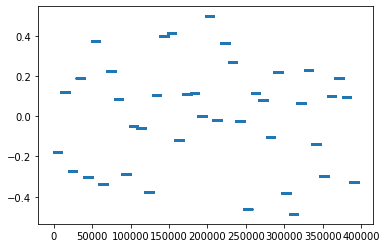

40

In [243]:
pl.scatter(np.arange(len(chain.T[0])),chain.T[0],s=1)
pl.show()
len(set(chain.T[0]))

In [242]:
#y_test, y_pred, std_pred, prec_pred
print([np.shape(elem) for elem in [network_predictions[1],network_predictions[3],train_mean,train_scatter]])
print(np.shape(network_predictions[1][:,0:2]))
print(np.shape(network_predictions[3][:,0:2,0:2]))
print(np.shape(train_mean[0:2]))
print(np.shape(train_scatter[0:2]))
n_p = 8
sampler = original_HI(1000,network_predictions[1][:,0:n_p],network_predictions[3][:,0:n_p,0:n_p],\
                      train_mean[0:n_p],train_scatter[0:n_p],n_param=n_p)
chain = sampler.chain[:,burnin:,:].reshape((-1,2*num_params))[:,0:num_params] #Just using the means for now

[(1000, 8), (1000, 8, 8), (8,), (8,)]
(1000, 2)
(1000, 2, 2)
(2,)
(2,)
SHAPES [(1000, 8), (1000, 8, 8), (8,), (8,)]


  0%|          | 0/10000 [00:00<?, ?it/s]/mnt/zfsusers/hollowayp/.local/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [00:54<00:00, 182.74it/s]


### Other HI

In [104]:
from paltas.Analysis.hierarchical_inference import gaussian_product_analytical

def fixed_param_HI(log_likelihood,n_emcee_samps=1e4):
    # sampling params
    n_walkers = 40
    ndim = 16
    n_emcee_samps = int(n_emcee_samps)

    def log_prior(hyperparameters):
        # uniform prior
        return 0

    def log_posterior(hyperparameters):
        lp = log_prior(hyperparameters)     
        if np.isfinite(lp):
            lp += log_likelihood(hyperparameters)
        return lp  
    cur_state_mu = np.concatenate([np.random.uniform(low=-4,high=4,size=(n_walkers,1))\
                                   for i in range(num_params)],axis=1)
    cur_state_sigmas = np.log(np.concatenate([np.random.uniform(low=0.01,high=2,size=(n_walkers,1))\
                                   for i in range(num_params)],axis=1))
    cur_state = np.concatenate((cur_state_mu,cur_state_sigmas),axis=1)
    sampler = emcee.EnsembleSampler(n_walkers, ndim,log_posterior)
    sampler.run_mcmc(cur_state,n_emcee_samps,progress=True,skip_initial_state_check=True)

    return sampler


def fixed_param_analytical_HI(n_lenses,y_pred,prec_pred,train_mean,train_scatter,n_emcee_samps=1e4):

    # network predictions to feed in
#    y_pred_hi = np.ascontiguousarray(y_pred[:n_lenses,:6]).reshape((n_lenses,6)).astype(np.float64)
#    prec_pred_hi = np.ascontiguousarray(prec_pred[:n_lenses,:6,:6]).reshape((n_lenses,6,6)).astype(np.float64)
    y_pred_hi = np.ascontiguousarray(y_pred[:n_lenses,:num_params]).reshape((n_lenses,num_params)).astype(np.float64)
    prec_pred_hi = np.ascontiguousarray(prec_pred[:n_lenses,:num_params,:num_params]).reshape((n_lenses,num_params,num_params)).astype(np.float64)

    # The interim training distribution.
    mu_omega_i = np.array(train_mean)
    cov_omega_i =np.diag(np.array(train_scatter)**2)
    prec_omega_i = np.linalg.inv(cov_omega_i)

    def log_likelihood(hyperparameters):    
        mus_omega = np.asarray([hyperparameters[0],0.,0.,hyperparameters[1],0.,0.])
        sigmas = np.asarray([hyperparameters[2],hyperparameters[3],hyperparameters[3],
                             hyperparameters[4],hyperparameters[5],hyperparameters[5]])
        # this inverse could be a possible issue
        prec_omega = np.linalg.inv(np.diag(sigmas**2))
        result = 0
        for p in range(0,np.shape(y_pred_hi)[0]):
            print(np.shape(gaussian_product_analytical(y_pred_hi[p,:],prec_pred_hi[p,:,:],
                mu_omega_i,prec_omega_i,mus_omega,prec_omega)))
            result += gaussian_product_analytical(y_pred_hi[p,:],prec_pred_hi[p,:,:],
                mu_omega_i,prec_omega_i,mus_omega,prec_omega)
            
        return result
    
    return fixed_param_HI(log_likelihood,n_emcee_samps)

print(np.shape(y_pred),np.shape(prec_pred),np.shape(train_mean),np.shape(train_scatter))
sampler = fixed_param_analytical_HI(n_lenses,y_pred,prec_pred,
                                 train_mean,train_scatter,n_emcee_samps=1e4)


(1000, 8) (1000, 8, 8) (8,) (8,)
emcee: Exception while calling your likelihood function:
  params: [ 3.4354019  -2.51576518 -1.71340708  0.71713917 -3.83369362  3.37263817
 -0.12866385 -0.12814199  0.0571906   0.43668194  0.54717716 -1.36391381
  0.29975709 -2.78620318 -0.30021908  0.27934133]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/mnt/zfsusers/hollowayp/.local/lib/python3.6/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-104-0eb018468843>", line 16, in log_posterior
    lp += log_likelihood(hyperparameters)
  File "<ipython-input-104-0eb018468843>", line 51, in log_likelihood
    mu_omega_i,prec_omega_i,mus_omega,prec_omega)))
ValueError: unable to broadcast argument 1 to output array
File "/mnt/zfsusers/hollowayp/paltas/paltas/Analysis/hierarchical_inference.py", line 112, 


ValueError: unable to broadcast argument 1 to output array
File "/mnt/zfsusers/hollowayp/paltas/paltas/Analysis/hierarchical_inference.py", line 112, 

# Results

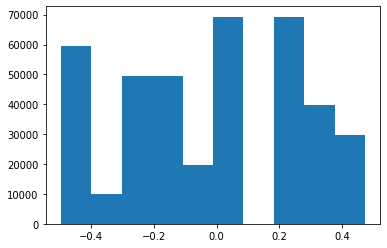

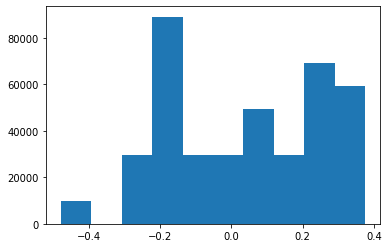

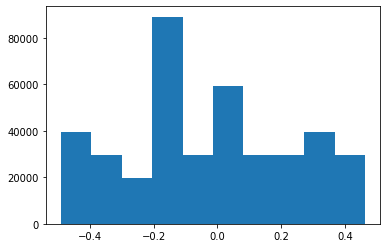

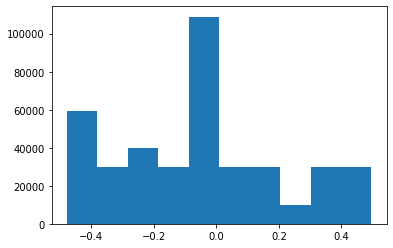

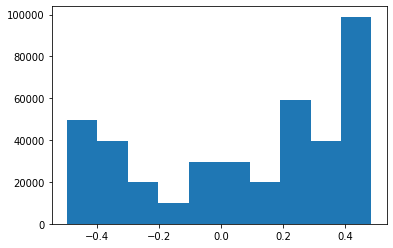

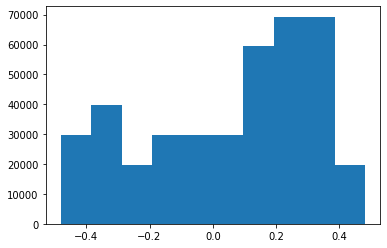

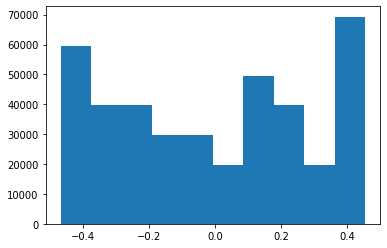

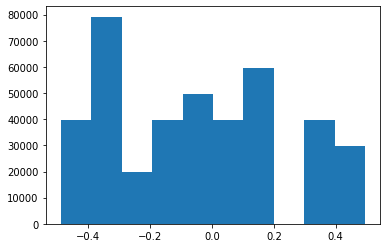

In [189]:
for i in range(8):
    pl.hist(chain[:,i])
    pl.show()

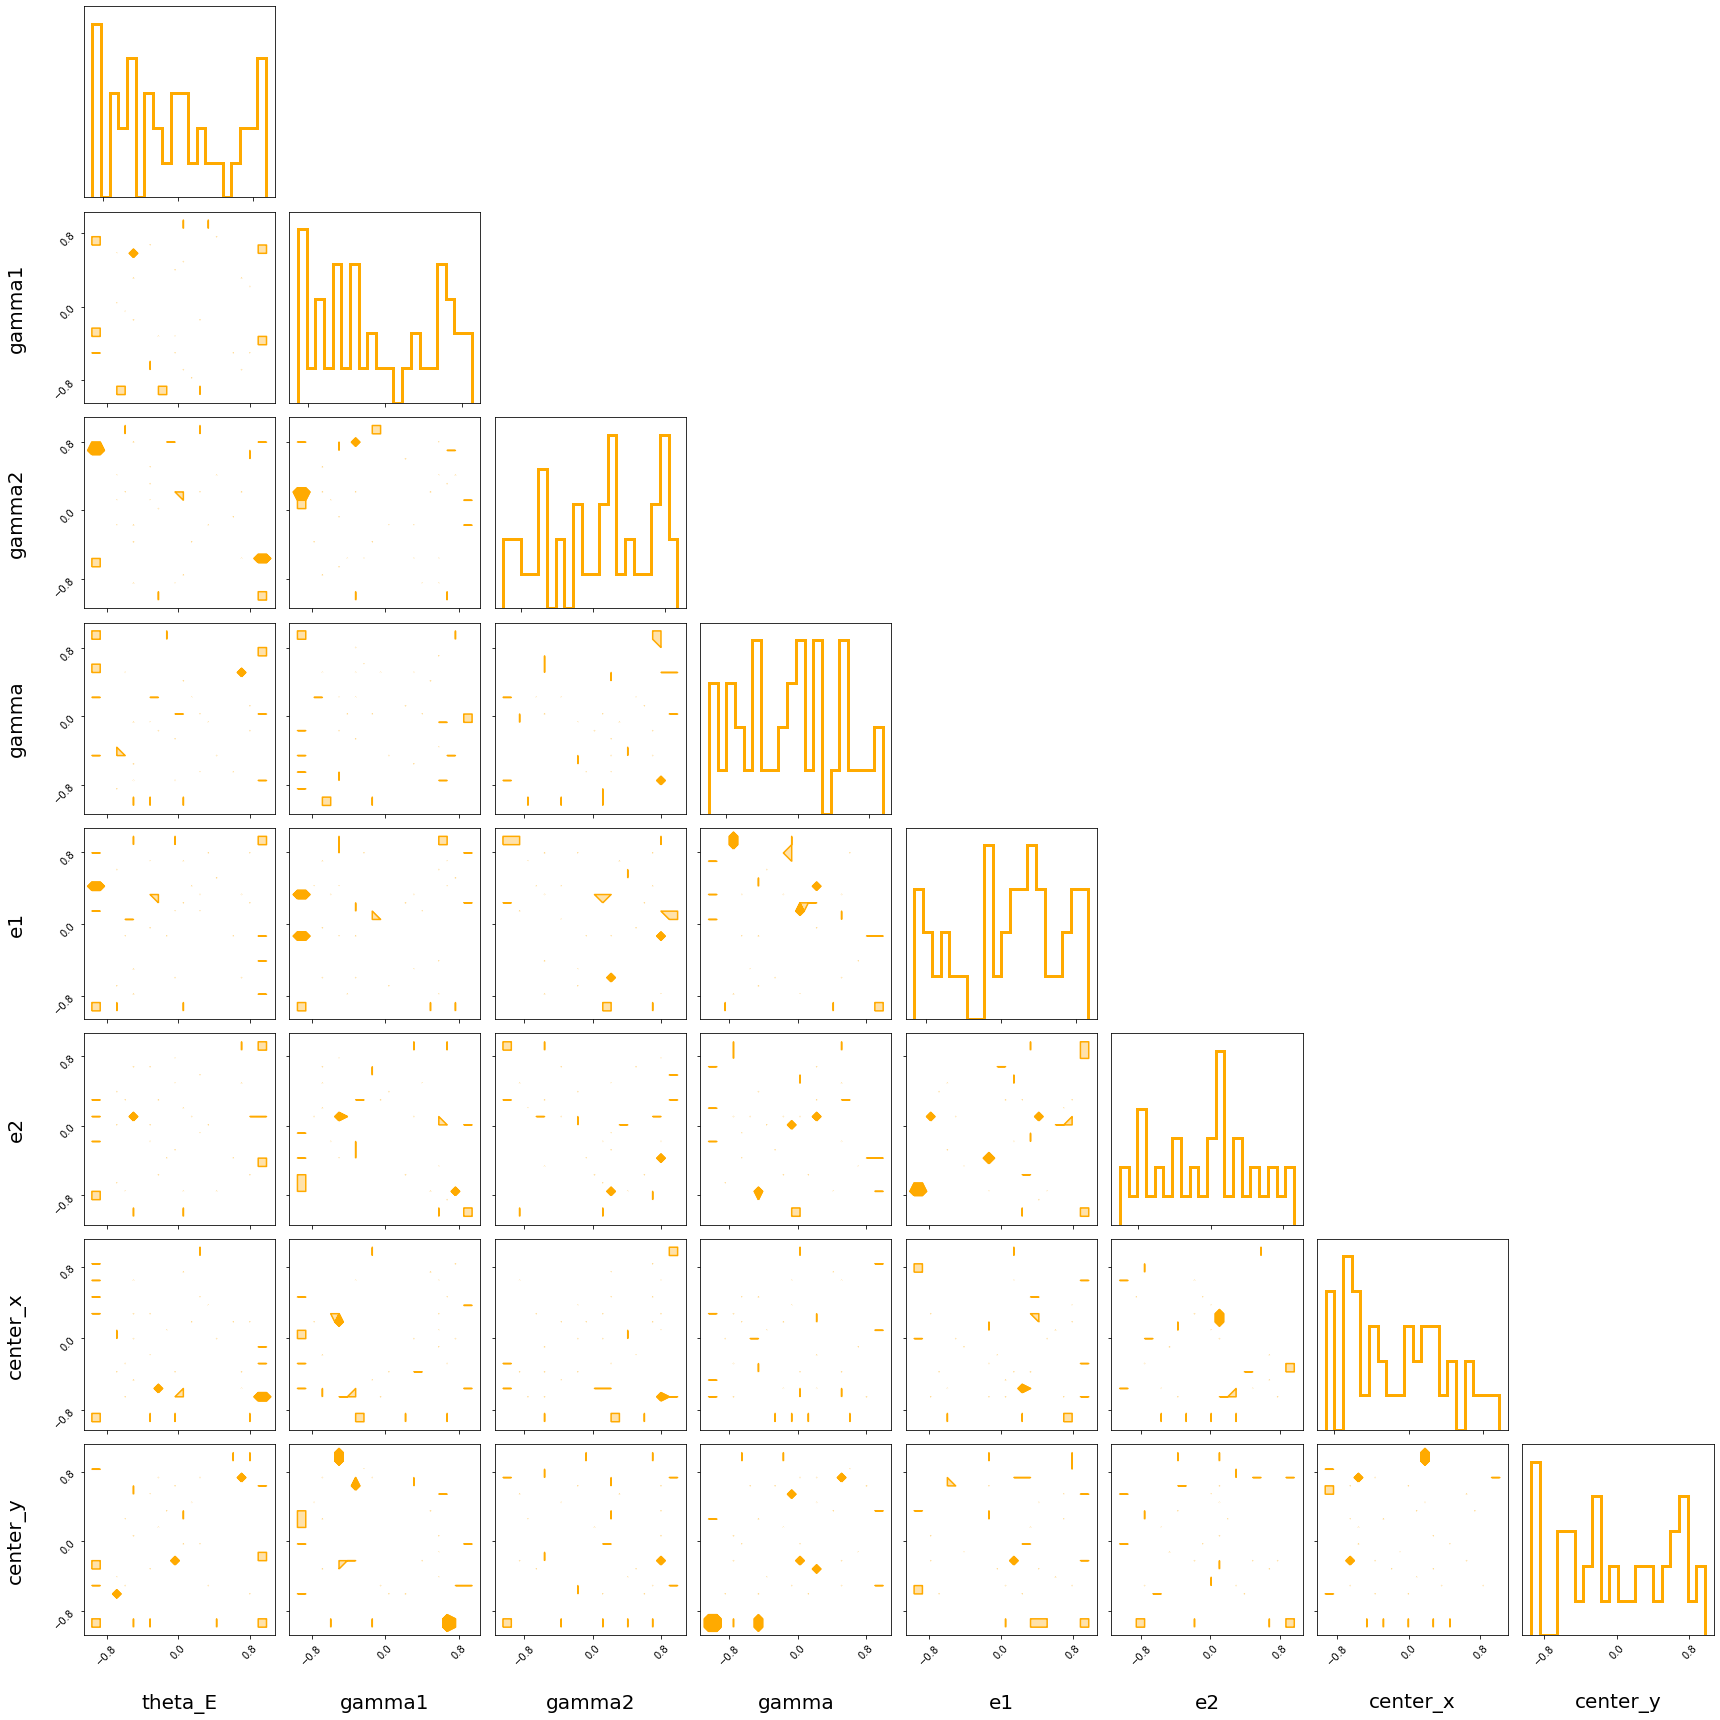

In [42]:
corner_param_print=[r'$\Sigma_\mathrm{sub,pop} \times 10^{3}$' + '\n' + r'$[\mathrm{kpc}^{-2}]$',
                    r'$\log \Sigma_\mathrm{sub,pop,\sigma} \times 10^{3}$' + '\n' + r'$[\mathrm{kpc}^{-2}]$']

corner_param_print= [elem.replace('main_deflector_parameters_','').replace('subhalo_parameters_','') for elem in learning_params]

fontsize = 20
color='#FFAA00'
truth_color = 'k'
hist_kwargs = {'density':True,'color':color,'lw':3}
fig = pl.figure(figsize=(3*len(learning_params),3*len(learning_params)))
corner.corner(chain,labels=corner_param_print,fig=fig,show_titles=False,plot_datapoints=False,\
              label_kwargs=dict(fontsize=fontsize),\
              levels=[0.68,0.95],color=color,fill_contours=True,hist_kwargs=hist_kwargs,title_fmt='.2f',\
#              truths=true_hyperparameters,truth_color=truth_color,\
              max_n_ticks=3,bins=20)

pl.tight_layout()
for format_i in ['png','pdf']:
    pl.savefig(paltas_directory+'/paltas/summary_plots/example_corner_plot.'+format_i)
pl.show()

